# Classifying irregularities in hands
### Author: Juliana Schneider
#### Project: Deep Learning, Hasso Plattner Institute
#### August 31st 2022

## Acknowledgements for Resources

I would like to thank the authors in the following tutorials, which were used to help build this project:  
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
https://www.pluralsight.com/guides/image-classification-with-pytorch  

## Load project / data

## Clone project and load data
Please clone the repository: https://github.com/junonsch/transfer_hands_demo.git


The dataset used in this project is the 11k Hands dataset that can be found here: https://sites.google.com/view/11khands. Please download the data into an appropriate folder in the project directory. See README for further instructions.

## Prepare data

This python script separates the data files into train, val and test folders. It is a 0.6 - 0.2 - 0.2 split and takes into account to split by ID.

In [ ]:
!python -m data_loading.py

## Preprocessing

In the resnet_run.py (or resnet_run_fine.py for resnet-34 finetuning models) files for each model, data_transforms are called. This is also where oversampling is applied for the models trained with oversampling.
The respective code parts look like this:
```python
DATA_TRANSFORMS = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
       transforms.RandomPerspective(distortion_scale=0.4),
       transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406],
[0.229, 0.224, 0.225])]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

```

```python
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
DATA_TRANSFORMS[x]) for x in ['train', 'val', 'test']}

# this is oversampling
def weighted_sampling(data):
    labels = [y[1] for y in data.imgs]
    labels_unique, counts = np.unique(labels, return_counts = True)
    class_weights = [sum(counts) / c for c in counts]
    example_weights = [class_weights[e] for e in labels]
    sampler = WeightedRandomSampler(example_weights, len(labels))
    
    return sampler

train_sampler = weighted_sampling(image_datasets["train"])

samplers = {"train": train_sampler,
           "val": None,
           "test": None}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=hyperparameter_defaults["batch_size"],
sampler=samplers[x], num_workers=4)

```

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

import random

data_dir = './data/hands/Hands/Hands/train/'

In [3]:
dataset = datasets.ImageFolder(data_dir, transform=transform)
classes = dict(zip(list(range(len(dataset.classes))),dataset.classes))

In [4]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

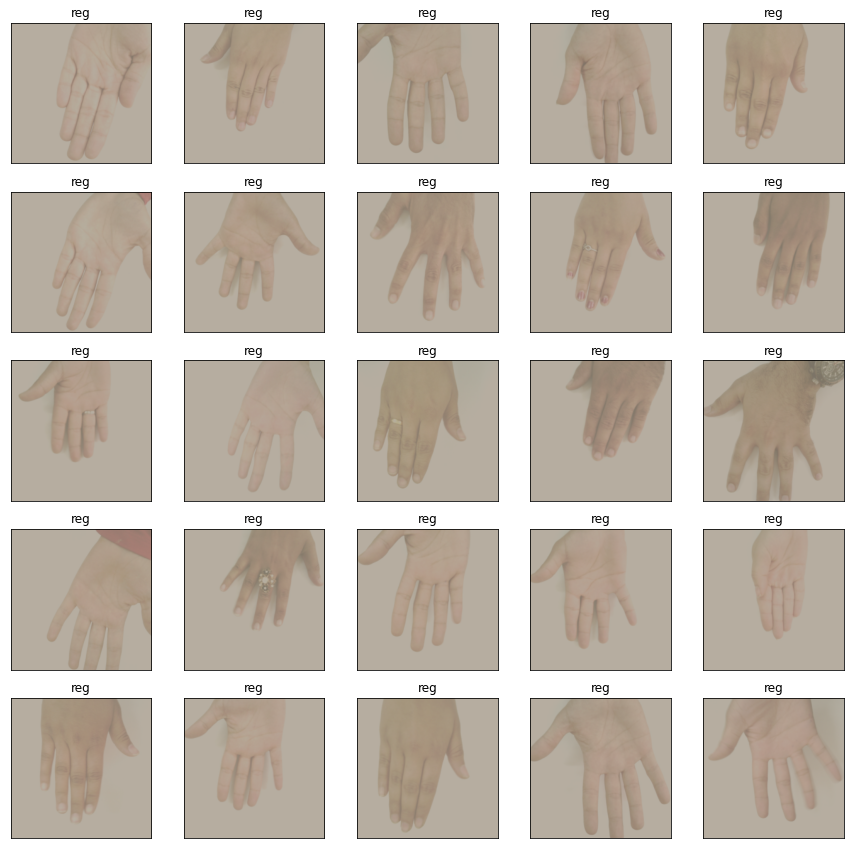

In [7]:
def denormalise(image):
    try:
        image = image.cpu().numpy().transpose(1, 2, 0)
    except:
        image = image.transpose(1, 2, 0) # PIL images have channel last
    mean = [0.485, 0.456, 0.406]
    stdd = [0.229, 0.224, 0.225]
    image = (image * stdd + mean).clip(0, 1)
    return image
  
dataiter = iter(dataloader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(15,15))

for idx in np.arange(25):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    ax.imshow(denormalise(images[idx]))#, cmap='gray')
    ax.set_title(classes[labels[idx].item()])

## models
- short description
- display architecture

In [5]:
from resnet34.model import model_conv as featex_resnet_model

In [6]:
from resnet34.model_fine import model_conv as finetune_resnet_model

There are two ways to use a pretrained model (here: resnet-34) for transfer learning: finetune the pretrained model or use it as a feature extractor. The models do not differ per sampling type (regular sample or oversampling) or performance metric (accuracy or F1-score).
The difference in the finetuned and the feature extractor resnet models look as follows in the code:
- finetuning:

```python
model_conv = torchvision.models.resnet34(pretrained=True)

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
```

- feature extraction:

```python
model_conv = torchvision.models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
```

## Model training

The training loop is essentially the same for all models except for different performance metrics (accuracy or F1-Score) being tracked and the best model being saved according to the performance metric.
Have a look at any train.py file.

Model training happens in the resnet_run.py or resnet_run_fine.py files.

## load trained model, validation loss values and accuracies

Let's load the model

In [63]:
from resnet34.model import model_conv as model_base
from resnet34f1.model import model_conv as model_base_f1
from overresnet34.model import model_conv as model_oversample
from overresnet34f1.model import model_conv as model_overf1

In [6]:
model_base.load_state_dict(torch.load("./results_resnet34/models/featex_resnet34model_conv_20220830-225228.pt",
                                     map_location=torch.device('cpu')))

<All keys matched successfully>

In [62]:
model_base_f1.load_state_dict(torch.load("./results_f1_resnet34/models/best_f1_featex_resnet34model_conv_20220831-161417.pt",
                                     map_location=torch.device('cpu')))

<All keys matched successfully>

In [9]:
model_oversample.load_state_dict(torch.load("./results_f1_overresnet34/models/featex_overresnet34model_conv_20220831-033635.pt",
                                     map_location=torch.device('cpu')))

<All keys matched successfully>

In [65]:
model_overf1.load_state_dict(torch.load("./results_f1_overresnet34/models/best_f1_featex_overresnet34model_conv_20220831-164217.pt",
                                     map_location=torch.device('cpu')))

<All keys matched successfully>

In [72]:
val_losses_base = torch.load("./results_resnet34/loss_values/featex_resnet34_loss_values_20220830-225228.pkl")

val_accs_base = torch.load("./results_resnet34/acc_values/featex_resnet34_acc_values_20220830-225228.pkl")

In [73]:
val_losses_oversample = torch.load("./results_overresnet34/loss_values/featex_overresnet34_loss_values_20220831-033635.pkl")

val_accs_oversample = torch.load("./results_overresnet34/acc_values/featex_overresnet34_acc_values_20220831-033635.pkl")

In [52]:
val_losses_overf1 = torch.load("./results_f1_overresnet34/loss_values/f1_featex_overresnet34_loss_values_20220831-164217.pkl")

val_accs_overf1 = torch.load("./results_f1_overresnet34/f1_values/f1_featex_overresnet34_f1_values_20220831-164217.pkl",
                            map_location=torch.device('cpu'))

In [59]:
val_losses_f1 = torch.load("./results_f1_resnet34/loss_values/f1_featex_resnet34_loss_values_20220831-161417.pkl")

val_accs_f1 = torch.load("./results_f1_resnet34/f1_values/f1_featex_resnet34_f1_values_20220831-161417.pkl",
                            map_location=torch.device('cpu'))

## model testing / evaluation

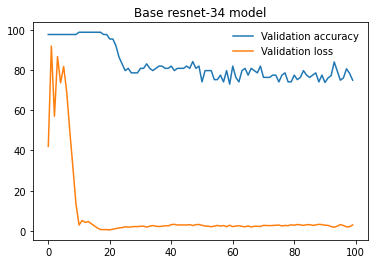

In [76]:
# 211116
# Plotting the graph for Validation and Training Losses wrt Steps
plt.title("Base resnet-34 model")
plt.plot(val_accs_base, label='Validation accuracy')
plt.legend(frameon=False)

plt.plot(val_losses_base, label='Validation loss')
plt.legend(frameon=False)
plt.savefig('base_val_loss_acc_resnet34.jpg')

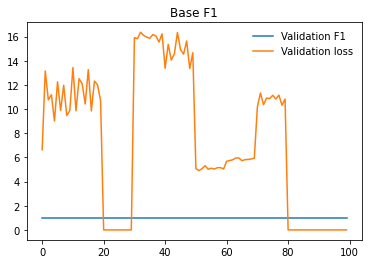

In [69]:
# 211116
# Plotting the graph for Validation and Training Losses wrt Steps
plt.title("Base F1")
plt.plot(val_accs_f1, label='Validation F1')
plt.legend(frameon=False)

plt.plot(val_losses_f1, label='Validation loss')
plt.legend(frameon=False)
plt.savefig('f1_val_loss_acc_resnet34.jpg')

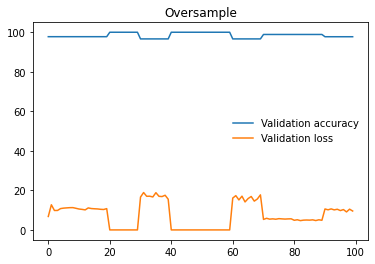

In [25]:
# 211116
# Plotting the graph for Validation and Training Losses wrt Steps
plt.title("Oversample")
plt.plot(val_accs_oversample, label='Validation accuracy')
plt.legend(frameon=False)

plt.plot(val_losses_oversample, label='Validation loss')
plt.legend(frameon=False)
plt.savefig('oversample_val_loss_acc_resnet34.jpg')

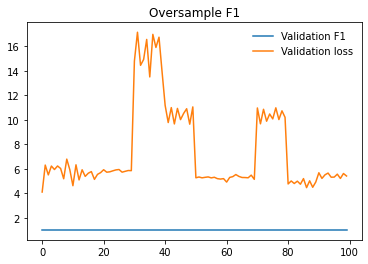

In [70]:
# 211116
# Plotting the graph for Validation and Training Losses wrt Steps
plt.title("Oversample F1")
plt.plot(val_accs_overf1, label='Validation F1')
plt.legend(frameon=False)

plt.plot(val_losses_overf1, label='Validation loss')
plt.legend(frameon=False)
plt.savefig('overf1_val_loss_acc_resnet34.jpg')

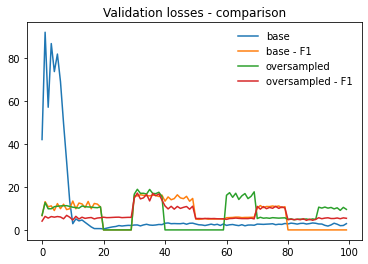

In [74]:
# 211116
# Plotting the graph for Validation and Training Losses wrt Steps
plt.title("Validation losses - comparison")
plt.plot(val_losses_base, label='base')
plt.legend(frameon=False)

plt.plot(val_losses_f1, label='base - F1')
plt.plot(val_losses_oversample, label='oversampled')
plt.plot(val_losses_overf1, label='oversampled - F1')

plt.legend(frameon=False)
plt.savefig('val_losses_comparison.jpg')

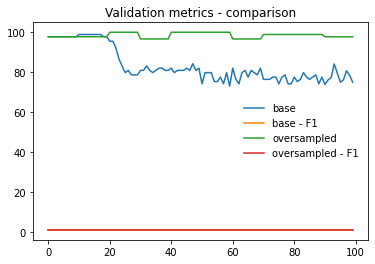

In [75]:
# 211116
# Plotting the graph for Validation and Training Losses wrt Steps
plt.title("Validation metrics - comparison")
plt.plot(val_accs_base, label='base - accuracy')
plt.legend(frameon=False)
plt.plot(val_accs_f1, label='base - F1')


# Plotting the graph for Validation accuracy wrt Steps
plt.plot(val_accs_oversample, label='oversampled - accuracy')
plt.plot(val_accs_overf1, label='oversampled - F1')

plt.legend(frameon=False)
plt.savefig('val_accs_comparison.jpg')

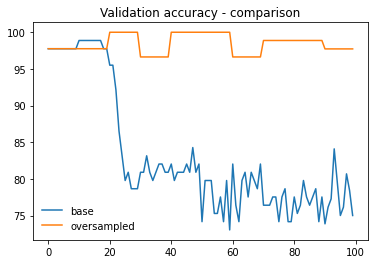

In [158]:
# 211116
# Plotting the graph for Validation and Training accs wrt Steps
plt.title("Validation accuracy - comparison")
plt.plot(val_accs_base, label='base')
plt.legend(frameon=False)

# Plotting the graph for Validation accuracy wrt Steps
plt.plot(val_accs_oversample, label='oversampled')
plt.legend(frameon=False)
#plt.savefig('val_accuracy_acc_resnet34.jpg')

## model comparison
- with plots

In [7]:
from test import evaluate_model
from general_config import loss_func, DATA_TRANSFORMS

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [9]:
data_dir = "./data/hands/Hands/Hands"

In [10]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          DATA_TRANSFORMS[x])
                  for x in ['train', 'val', 'test']}

In [11]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

In [12]:
from tqdm import tqdm

In [13]:
from torchmetrics import F1Score


In [14]:
import numpy as np

In [159]:
evaluate_model(model_base, classes, dataloaders, device, loss_func)

First stage


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [10:37<00:00, 127.54s/it]


Test Loss: 4.977571

Second stage


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 6260.16it/s]

Test Accuracy of     0: 0.00% ( 0/250)
Test Accuracy of     1: 100.00% (10725/10725)

Test Accuracy (Overall): 97.72% (10725/10975)


{'test_acc_0': 0.0, 'test_acc_1': 100.0, 'test_acc_overall': 97.72209567198178}

In [160]:
evaluate_model(model_oversample, classes, dataloaders, device, loss_func)

First stage


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [11:39<00:00, 139.90s/it]


Test Loss: 10.828478

Second stage


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2915.75it/s]

Test Accuracy of     0: 0.00% ( 0/250)
Test Accuracy of     1: 100.00% (10725/10725)

Test Accuracy (Overall): 97.72% (10725/10975)


{'test_acc_0': 0.0, 'test_acc_1': 100.0, 'test_acc_overall': 97.72209567198178}

In [67]:
evaluate_model(model_base_f1, classes, dataloaders, device, loss_func)

First stage
Test Loss: 7.062073

Second stage
Test Accuracy of     0: 0.00% ( 0/250)
Test Accuracy of     1: 100.00% (10725/10725)

Test Accuracy (Overall): 97.72% (10725/10975)


{'test_acc_0': 0.0, 'test_acc_1': 100.0, 'test_acc_overall': 97.72209567198178}

In [68]:
evaluate_model(model_overf1, classes, dataloaders, device, loss_func)

First stage
Test Loss: 8.298140

Second stage
Test Accuracy of     0: 0.00% ( 0/250)
Test Accuracy of     1: 100.00% (10725/10725)

Test Accuracy (Overall): 97.72% (10725/10975)


{'test_acc_0': 0.0, 'test_acc_1': 100.0, 'test_acc_overall': 97.72209567198178}